<a href="https://colab.research.google.com/github/Ashishantal/AshishAntal.github.io/blob/main/Colorization_of_historical_photographs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# change these if you like
INPUT_DIR = '/content/colorize_inputs'    # put your 72 images here
OUTPUT_DIR = '/content/colorize_outputs'
MODEL_DIR = '/content/models_colorization'

In [4]:
import os
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [5]:
print("Input:", INPUT_DIR)
print("Output:", OUTPUT_DIR)
print("Model:", MODEL_DIR)

Input: /content/colorize_inputs
Output: /content/colorize_outputs
Model: /content/models_colorization


In [6]:
# run in a code cell (bang)
!pip install -q scikit-image


In [16]:
%cd /content

!cd /content/models_colorization

# Caffe model (weights)
!wget -q --show-progress http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel

# Prototxt (network definition)
!wget -q https://raw.githubusercontent.com/richzhang/colorization/caffe/models/colorization_deploy_v2.prototxt

# cluster centers used by the model
!wget -q https://raw.githubusercontent.com/richzhang/colorization/caffe/resources/pts_in_hull.npy

!ls -l


/content
total 80
-rw-r--r-- 1 root root 9945 Sep 17 13:56 colorization_deploy_v2.prototxt
-rw-r--r-- 1 root root 9945 Sep 17 13:56 colorization_deploy_v2.prototxt.1
-rw-r--r-- 1 root root 9945 Sep 17 14:02 colorization_deploy_v2.prototxt.2
drwxr-xr-x 3 root root 4096 Sep 17 13:57 colorize_inputs
drwxr-xr-x 2 root root 4096 Sep 17 13:53 colorize_outputs
drwx------ 5 root root 4096 Sep 17 13:50 drive
drwxr-xr-x 2 root root 4096 Sep 17 13:54 models_colorization
-rw-r--r-- 1 root root 5088 Sep 17 13:56 pts_in_hull.npy
-rw-r--r-- 1 root root 5088 Sep 17 13:56 pts_in_hull.npy.1
-rw-r--r-- 1 root root 5088 Sep 17 14:02 pts_in_hull.npy.2
drwxr-xr-x 1 root root 4096 Sep 17 13:53 sample_data


In [18]:
%cd /content/models_colorization

# Download the prototxt file
!wget -q https://raw.githubusercontent.com/richzhang/colorization/caffe/models/colorization_deploy_v2.prototxt -O colorization_deploy_v2.prototxt

# Download the pts_in_hull numpy cluster centers
!wget -q https://raw.githubusercontent.com/richzhang/colorization/caffe/resources/pts_in_hull.npy -O pts_in_hull.npy

# Download the caffemodel from the OpenVINO storage mirror
!wget -q https://storage.openvinotoolkit.org/repositories/datumaro/models/colorization/colorization_release_v2.caffemodel -O colorization_release_v2.caffemodel

# If the OpenVINO link doesn’t work or is blocked, fallback: HuggingFace link
!wget -q https://huggingface.co/spaces/BilalSardar/Black-N-White-To-Color/resolve/main/colorization_release_v2.caffemodel -O colorization_release_v2_hf.caffemodel


/content/models_colorization


In [19]:
!ls -lh /content/models_colorization


total 246M
-rw-r--r-- 1 root root 9.8K Sep 17 14:06 colorization_deploy_v2.prototxt
-rw-r--r-- 1 root root 123M Oct  8  2024 colorization_release_v2.caffemodel
-rw-r--r-- 1 root root 123M Sep 17 14:06 colorization_release_v2_hf.caffemodel
-rw-r--r-- 1 root root 5.0K Sep 17 14:06 pts_in_hull.npy


In [24]:
import cv2
import numpy as np
import os
from pathlib import Path

MODEL_DIR = '/content/models_colorization'
proto = os.path.join(MODEL_DIR, 'colorization_deploy_v2.prototxt')
model = os.path.join(MODEL_DIR, 'colorization_release_v2.caffemodel')
pts_in_hull = os.path.join(MODEL_DIR, 'pts_in_hull.npy')

net = cv2.dnn.readNetFromCaffe(proto, model)
pts = np.load(pts_in_hull)

# Setup layers
class8_id = net.getLayerId('class8_ab')
conv8_id = net.getLayerId('conv8_313_rh')
pts2 = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8_id).blobs = [pts2.astype(np.float32)]
net.getLayer(conv8_id).blobs = [np.full((1, 313), 2.606, dtype=np.float32)]

def colorize_opencv(in_path, out_path, net, W=224, H=224):
    # Load grayscale image
    bgr = cv2.imread(in_path)
    if bgr is None:
        print(" Failed to read:", in_path)
        return
    h, w = bgr.shape[:2]

    # Convert to Lab color space
    img_rgb = (bgr.astype("float32") / 255.0)
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
    L = img_lab[:, :, 0]  # extract L channel

    # Resize to network input size
    L_rs = cv2.resize(L, (W, H))  # 224x224
    L_rs = L_rs - 50  # mean-centering as per model

    # Predict 'ab' channels
    net.setInput(cv2.dnn.blobFromImage(L_rs))
    ab_dec = net.forward()[0, :, :, :].transpose((1, 2, 0))  # shape 56x56x2

    # Resize to original image size
    ab_dec_us = cv2.resize(ab_dec, (w, h))

    # Concatenate with original L channel
    out_lab = np.concatenate((L[:, :, np.newaxis], ab_dec_us), axis=2)

    # Convert back to BGR
    out_bgr = cv2.cvtColor(out_lab.astype("float32"), cv2.COLOR_LAB2BGR)

    # Clip and scale
    out_bgr = np.clip(out_bgr, 0, 1)
    out_bgr = (255 * out_bgr).astype("uint8")

    cv2.imwrite(out_path, out_bgr)
    print(" Saved:", out_path)


# Test on one
sample_in = '/content/colorize_inputs/bw (65).jpg'
sample_out = '/content/colorize_outputs/example_colori.jpg'
colorize_opencv(sample_in, sample_out, net)
print("Saved:", sample_out)


✅ Saved: /content/colorize_outputs/example_colori.jpg
Saved: /content/colorize_outputs/example_colori.jpg


In [26]:
import glob, os

input_dir = "/content/colorize_inputs"
output_dir = "/content/colorize_outputs"
os.makedirs(output_dir, exist_ok=True)

# Process all JPG/PNG images
for img_path in glob.glob(os.path.join(input_dir, "*.*")):
    fname = os.path.basename(img_path)
    out_path = os.path.join(output_dir, fname)
    colorize_opencv(img_path, out_path, net)

print(" Finished processing all images!")


✅ Saved: /content/colorize_outputs/bw (14).jpg
✅ Saved: /content/colorize_outputs/bw (15).jpg
✅ Saved: /content/colorize_outputs/bw (59).jpg
✅ Saved: /content/colorize_outputs/bw (32).jpg
✅ Saved: /content/colorize_outputs/bw (35).jpg
✅ Saved: /content/colorize_outputs/bw (16).jpg
✅ Saved: /content/colorize_outputs/bw (4).jpg
✅ Saved: /content/colorize_outputs/bw (2).jpg
✅ Saved: /content/colorize_outputs/bw (58).jpg
✅ Saved: /content/colorize_outputs/bw (18).jpg
✅ Saved: /content/colorize_outputs/bw (3).jpg
✅ Saved: /content/colorize_outputs/bw (5).jpg
✅ Saved: /content/colorize_outputs/bw (33).jpg
✅ Saved: /content/colorize_outputs/bw (62).jpg
✅ Saved: /content/colorize_outputs/bw (50).jpg
✅ Saved: /content/colorize_outputs/bw (44).jpg
✅ Saved: /content/colorize_outputs/bw (41).jpg
✅ Saved: /content/colorize_outputs/bw (38).jpg
✅ Saved: /content/colorize_outputs/bw (8).jpg
✅ Saved: /content/colorize_outputs/bw (61).jpg
✅ Saved: /content/colorize_outputs/bw (21).jpg
✅ Saved: /content/

✅ Saved: /content/colorize_outputs/example_1.jpg


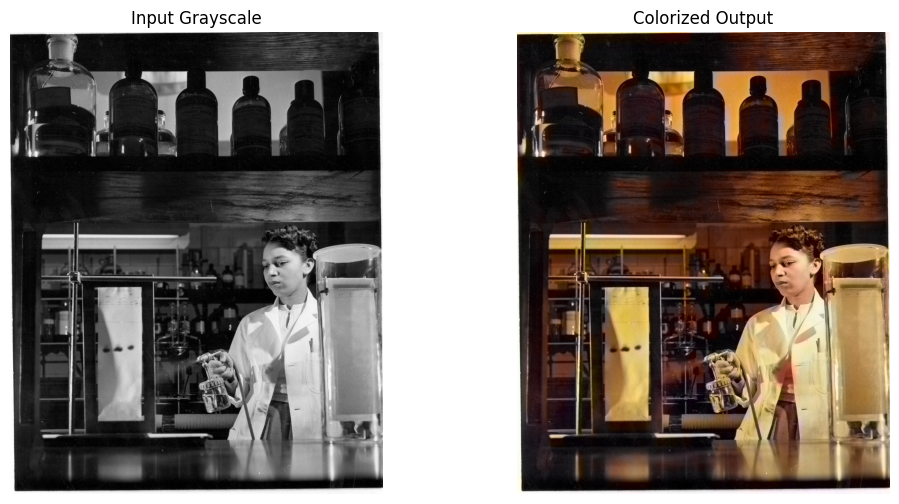

In [28]:
import matplotlib.pyplot as plt
import cv2
import os

# Example input/output paths
sample_in = "/content/colorize_inputs/example_1.jpg"
sample_out = "/content/colorize_outputs/example_1.jpg"

# Run colorization first
colorize_opencv(sample_in, sample_out, net)

# Load images
gray = cv2.imread(sample_in, cv2.IMREAD_GRAYSCALE)
color = cv2.imread(sample_out)

# Convert BGR (OpenCV) to RGB (matplotlib expects RGB)
color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)

# Show side by side
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Input Grayscale")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Colorized Output")
plt.imshow(color)
plt.axis("off")

plt.show()


In [ ]:
import gradio as gr
import cv2
import numpy as np

def colorize_interface(img):
    # Convert uploaded image (PIL → OpenCV format)
    bgr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    h, w = bgr.shape[:2]

    # Convert to LAB and preprocess
    img_rgb = bgr.astype("float32") / 255.0
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
    L = img_lab[:,:,0]
    L_rs = cv2.resize(L, (224, 224))
    L_rs = L_rs - 50

    # Run model
    net.setInput(cv2.dnn.blobFromImage(L_rs))
    ab_dec = net.forward()[0,:,:,:].transpose((1,2,0))
    ab_us = cv2.resize(ab_dec, (w, h))

    # Merge back
    out_lab = np.concatenate((L[:,:,np.newaxis], ab_us), axis=2)
    out_bgr = cv2.cvtColor(out_lab.astype("float32"), cv2.COLOR_LAB2RGB)
    out_bgr = np.clip(out_bgr, 0, 1)
    out_bgr = (255 * out_bgr).astype("uint8")

    return img, out_bgr  # returns both grayscale input and colorized output

# Gradio GUI
demo = gr.Interface(
    fn=colorize_interface,
    inputs=gr.Image(type="pil", label="Upload Grayscale Image"),
    outputs=[gr.Image(type="numpy", label="Grayscale Input"),
             gr.Image(type="numpy", label="Colorized Output")],
    title="Historical Photo Colorizer",
    description="Upload a black-and-white photo and get a colorized version."
)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0ba9167081fd1e73a4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
